In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

import glob
import time
import sklearn.svm as svm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV




In [3]:
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# class save_images ( object ):
#     def __init__( self ):
#         self.i = 0
#     def __call__( self, image):
#         # do somethingc
#         self.i +=1
#         cv2.imwrite("test_images_project/image" + str(self.i) + ".jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
#         return image
    
# save_images = save_images()    
    
# ## creating additional test images
# from moviepy.editor import VideoFileClip
# output_video_name = 'test_video_output.mp4'
# clip1 = VideoFileClip("project_video.mp4")
# clip2 = clip1.subclip(0,15)
# output_video = clip2.fl_image(lambda x:save_images(x)) #NOTE: this function expects color images!!
# %time output_video.write_videofile(output_video_name, audio=False)
# import os
# os.remove('test_video_output.mp4')
# print ("Completed")


[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 15%|█▌        | 57/376 [00:03<00:27, 11.51it/s]

KeyboardInterrupt: 

Completed


## image_features_extractor

In [4]:
class image_features_extractor:
    def __init__(self    \
        ,color_space           # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        ,orient                # HOG orientations 
        ,pix_per_cell          # HOG pixels per cell 
        ,cell_per_block        # HOG cells per block 
        ,spatial_size          # Spatial binning dimensions
        ,spatial_feat          # Spatial features on or off
        ,hist_feat             # Histogram features on or off
        ,hog_feat              # HOG features on or off
        ,nbins                 # Number of color histogram bins
        ,bins_range
        ,image_size
        ,debug=False
                ):

        self.color_space = color_space
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.spatial_size = spatial_size
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.nbins=nbins
        self.bins_range=bins_range
        self.debug =debug
        self.image_size = image_size

    # Define a function to compute binned color features  
    def bin_spatial(self,feature_image):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(feature_image, self.spatial_size).ravel() 
        # Return the feature vector
        return features

    # Define a function to compute color histogram features  
    def color_hist(self,feature_image):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(feature_image[:,:,0], bins=self.nbins, range=self.bins_range)
        channel2_hist = np.histogram(feature_image[:,:,1], bins=self.nbins, range=self.bins_range)
        channel3_hist = np.histogram(feature_image[:,:,2], bins=self.nbins, range=self.bins_range)
        # Concatenate the histograms into a single feature vector
        self.hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
#         hist_features = channel1_hist[0]

        if self.debug:
            # Generating bin centers
            bin_edges = channel1_hist[1]
            bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
            # Plot a figure with all three bar charts
            fig = plt.figure(figsize=(12,3))
            plt.subplot(131)
            plt.bar(bin_centers, channel1_hist[0])
            plt.xlim(0, 256)
            plt.title('Channel 0 Histogram')
            plt.subplot(132)
            plt.bar(bin_centers, channel2_hist[0])
            plt.xlim(0, 256)
            plt.title('Channel 1 Histogram')
            plt.subplot(133)
            plt.bar(bin_centers, channel3_hist[0])
            plt.xlim(0, 256)
            plt.title('Channel 2 Histogram')
            plt.show()

       
        # Return the individual histograms, bin_centers and feature vector
        return self.hist_features

    def get_hog_features(self, feature_image):
        if self.debug:
            # feature_image is 1 channel image
            hog_features ,hog_image    = hog(feature_image, 
                                  orientations=self.orient, 
                                  pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                  cells_per_block=(self.cell_per_block, self.cell_per_block), 
                                  block_norm='L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=True, feature_vector=True)

            plt.imshow(hog_image)
            plt.title("Histogram of Oriented Gradients")
            plt.axis("off")
            plt.show()
            return hog_features

        
        else:
            # feature_image is 1 channel image
            hog_features     = hog(feature_image, 
                                  orientations=self.orient, 
                                  pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                  cells_per_block=(self.cell_per_block, self.cell_per_block), 
                                  block_norm='L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=False, feature_vector=True)
            return hog_features



    def get_all_features (self, img):
        if self.debug:
            print( "get_all_features image shape "+ str(img.shape))
        if self.color_space != 'RGB':
            if self.color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif self.color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif self.color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif self.color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif self.color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)
            
        
        if feature_image.shape[0] == self.image_size[0] and\
           feature_image.shape[1] == self.image_size[1]:
            pass #print (" feature_image.shape == self.image_size")
        else:
             print (" feature_image.shape = " + str(feature_image.shape))
             print (" self.image_size = "     + str(self.image_size))
             feature_image = cv2.resize(feature_image, self.image_size)    
                
        if self.debug:
            f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
            f.tight_layout()
            

            ax1.imshow(feature_image[:,:,0],cmap="gray")
            ax1.set_title("Image in format " + self.color_space + " channel 0 ")
            ax1.axis('off')
            
            ax2.imshow(feature_image[:,:,1],cmap="gray")
            ax2.set_title("Image in format " + self.color_space+ " channel 1 ")
            ax2.axis('off')

            ax3.imshow(feature_image[:,:,2],cmap="gray")
            ax3.set_title("Image in format " + self.color_space+ " channel 2 ")
            ax3.axis('off')

            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
            plt.show()


            
        img_features = []

        if self.spatial_feat == True:
            img_features.append(self.bin_spatial(feature_image))

        if self.hist_feat == True:
            img_features.append(self.color_hist(feature_image))
            
        if self.hog_feat == True:
#             gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#             hog_features = self.get_hog_features(gray_image)
            hog_features = []
            for channel in range(feature_image.shape[2]):
                temp = self.get_hog_features(feature_image[:,:,channel])
                hog_features.extend(temp)      
            img_features.append(hog_features)
            
        #9) Return concatenated array of features
    #     print (img_features)
        return np.concatenate(img_features)                
    

### Car Detector from images ( train & prediction )

In [5]:
class image_car_detector:
    def __init__(self, extractor, 
                 cars_folder='train_data/car', 
                 notcars_folder='train_data/non-car',
                 limit_images=None):
        self.cars_folder    = cars_folder
        self.notcars_folder = notcars_folder

        self.car_images_list     = []
        self.notcars_images_list = []
        self.extractor = extractor
        
        self.car_features = []
        self.notcar_features = []
        self.limit_images = limit_images

        
    def load_images_list(self):
        self.car_images_list     = []
        self.notcars_images_list = []
    
        # loading cars
        for subfolder in glob.glob(self.cars_folder + '/*'):
          print ("subfolder = " + subfolder)
          for image  in  glob.glob(subfolder+'/*'):
               self.car_images_list.append(image)

        # loading non cars
        for subfolder in glob.glob(self.notcars_folder+ '/*'):
          for image  in  glob.glob(subfolder+'/*'):
               self.notcars_images_list.append(image)
    
    # Define a function to extract features from a list of images
    # Have this function call bin_spatial() and color_hist()
    def extract_imgs_features(self):
        # Iterate through the list of images
        if self.limit_images:
            x_limit = self.limit_images
            print (" limiting the number of images to " + str(x_limit))
        else:
            x_limit = len(self.car_images_list)
            print (" processing " + str(x_limit) +" images "  )

#         x_limit = 100
        print ( " ")
        print (" Extracting features from cars ....")
        # CARS FEATURES 
        self.car_features = []


        for file in self.car_images_list[:x_limit]:
            image = cv2.imread(file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            temp_features = self.extractor.get_all_features(image)
#             print ( " features length = " + str(len(temp_features)))
            self.car_features.append(temp_features)
            
        print (" .. completed ( features per image = " + str(len(self.car_features[0])) + ")")

            
        print ( " ")
        print (" Extracting features from non cars ....")
        # NOT CAR FEATURES 
        self.notcar_features = []
        # Iterate through the list of images
        for file in self.notcars_images_list[:x_limit]:
            image = cv2.imread(file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            temp_features = self.extractor.get_all_features(image)
#             print ( " features length = " + str(len(temp_features)))
            self.notcar_features.append(temp_features)
        print (" .. completed ( features per image = " + str(len(self.notcar_features[0])) + ")")

        print (" ")

        
  


    def search_windows(self, img, windows, cars_classifier):
        self.on_windows = []
        for window in windows:
            #3) Extract the test window from original image
            ###[startx, starty, endx, endy]
            test_img = img[window[1]:window[3], window[0]:window[2]]
            test_img = cv2.resize(test_img, (64,64))
            
            if cars_classifier.type == "CNN":
                prediction = cars_classifier.predict(test_img)
    
            else:
                #4) Extract features for that window using single_img_features()
                features = self.extractor.get_all_features(test_img)
                features_reshaped = np.array(features).reshape(1, -1)
                #5) Scale extracted features to be fed to classifier
                test_features = cars_classifier.X_scaler.transform(np.array(features).reshape(1, -1))
                #6) Predict using your classifier
                prediction = cars_classifier.clf.predict(test_features)
            
            #7) If positive (prediction == 1) then save the window
            if prediction == "car":
#                 print(window)
                self.on_windows.append(window)
#                 print ( "prediction = 1 ")
#                 plt.title("prediction = 1 ")
#             else:
#                 plt.title("prediction = 0 ")

#             plt.axis('off')
#             plt.imshow(test_img)
#             plt.show()


                
        return self.on_windows

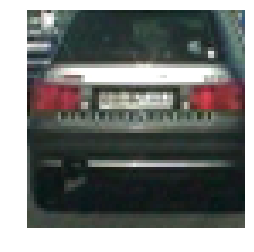

get_all_features image shape (64, 64, 3)


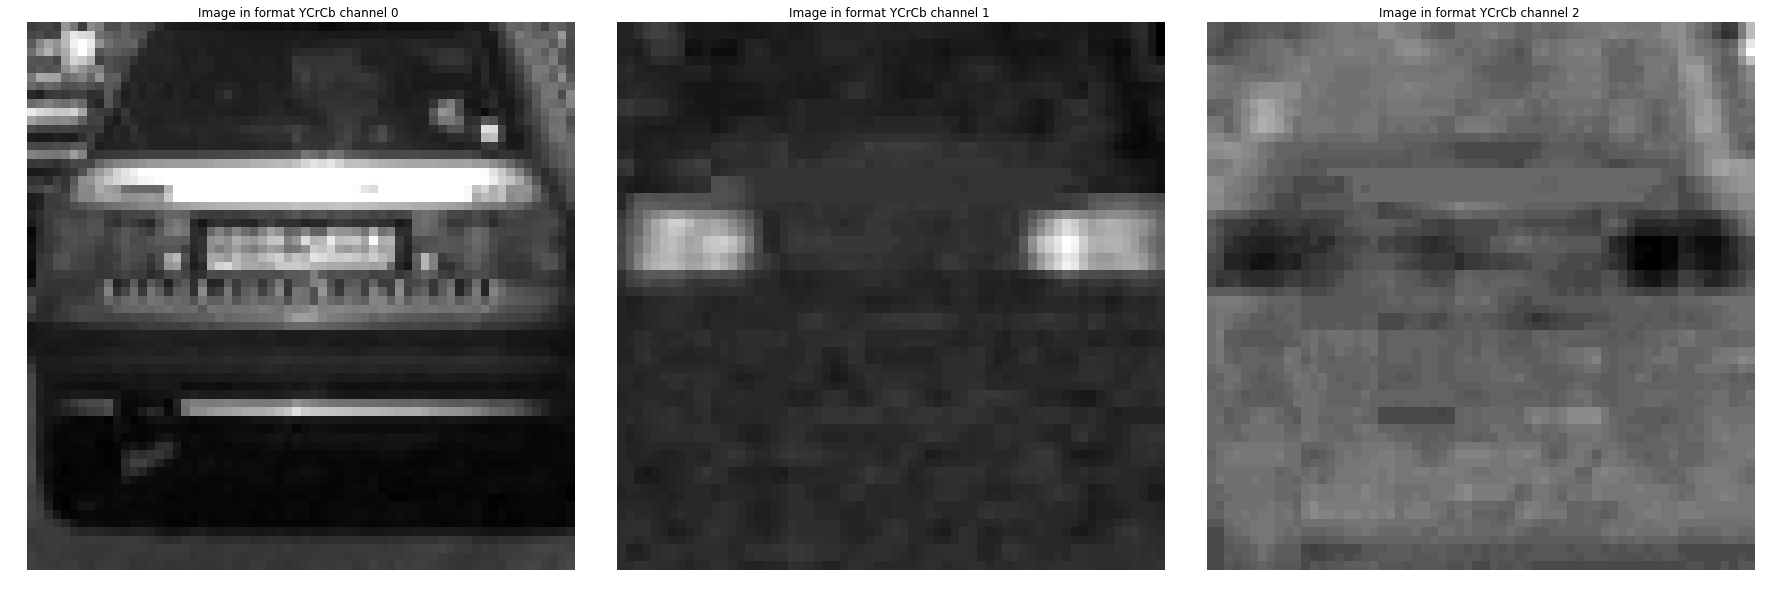

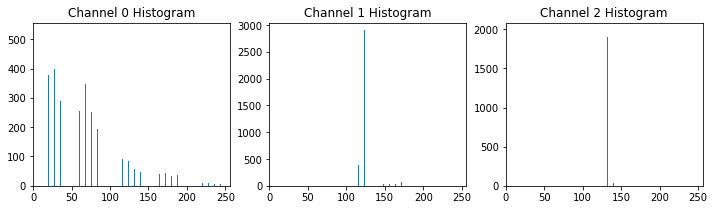

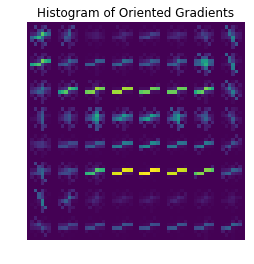

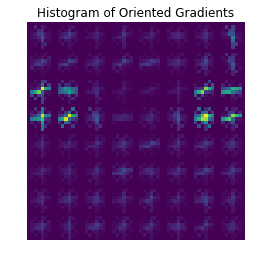

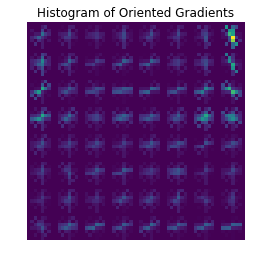

(8460,)

In [6]:
import cv2
image = cv2.imread('train_data/car/GTI_MiddleClose/image0110.png')
image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# color space = RGB, HSV, LUV, HLS, YUV, YCrCb
extractor = image_features_extractor(color_space= 'YCrCb' #'YCrCb'
                                    ,pix_per_cell=8
                                    ,cell_per_block=2
                                     
                                    ,orient=9
                                    ,spatial_feat = True     # Spatial features on or off
                                    ,hist_feat = True        # Histogram features on or off
                                    ,hog_feat = True  
                                    ,spatial_size = (32, 32)
                                    ,bins_range=(0, 256)
                                    ,nbins=32
                                    , debug=True
                                    , image_size = (64,64)  
                                    )
plt.imshow(image)
plt.axis("off")
plt.show()

all_features = extractor.get_all_features(image)
all_features.shape


### Defining the classifier HOG + Neural Network

In [7]:
class classifier_hog_nn:
    def __init__(self, car_features, notcar_features):
        self.car_features = car_features
        self.notcar_features = notcar_features
        self.type="HOG+NEURAL"
                 
    def train(self, parameters=[1, 10], epochs=20,batch_size = 32,verbose =False):
        
        X = np.vstack((self.car_features, self.notcar_features)).astype(np.float64)                        

        print (".....Scaling...")
        # Fit a per-column scaler
        self.X_scaler = StandardScaler().fit(X)
        
        # Apply the scaler to X
        scaled_X = self.X_scaler.transform(X)
        print (scaled_X)
        
        y = np.hstack((np.ones(len(self.car_features)), np.zeros(len(self.notcar_features))))

        from sklearn.model_selection import train_test_split

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            scaled_X, y, test_size=0.1, random_state=rand_state)

        #################
        # #### START TRAINING 
        #################

        import time

        print ( "Start training ... ")
        t=time.time()
        from keras.models import Sequential
        from keras.layers import Dense, Dropout
        from keras.utils import to_categorical
        
        self.clf = Sequential()
        
        self.clf.add(Dense(32, input_shape=(len(self.car_features[0]),), name="dense1"))
        self.clf.add(Dense(64, activation='relu', name="dense2"))
        self.clf.add(Dropout(0.2))
        self.clf.add(Dense(64, activation='relu', name="dense3"))
        self.clf.add(Dense(1024, activation='relu', name="dense4"))
        self.clf.add(Dropout(0.2))
        self.clf.add(Dense(1, activation='sigmoid', name="final"))

        
        self.clf.compile('adam', 'binary_crossentropy', ['accuracy'])

            
        history = self.clf.fit(self.X_train, self.y_train,
                    batch_size=batch_size,
                    epochs = epochs,
                    verbose=verbose,
                    shuffle=True,
                    validation_split=0.1,           
                    )
                  
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train the classifier...')

        # Check the score of the SVC
        score = self.clf.evaluate(self.X_test, self.y_test)

#         print('Test Accuracy of SVC = ', round(self.clf.score(X_test, y_test), 4))
        print( " ")
        print('Test Accuracy of classifier = ' + str(score[1]))

    def predict(self, features):
        prediction = self.clf.predict(features).squeeze()
        if prediction >  0.9:
            return "car"
        else:
            return "non-car"
        
        
    
    def save_classifier(self):
        self.clf.save("keras_model.h5")
        
        import pickle
#         # save the classifier
#         with open('car_detection_classifier.pkl', 'wb') as fid:
#             pickle.dump(self.clf, fid) 
            
        with open('X_scaler.pkl', 'wb') as fid:
            pickle.dump(self.X_scaler, fid) 
        print (" .. classifier saved ")    

    def load_classifier(self):
        import pickle
        # save the classifier
#         with open('car_detection_classifier.pkl', 'rb') as fid:
#             self.clf = pickle.load(fid)
        from keras.models import load_model
        self.clf = load_model("keras_model.h5")
        
        with open('X_scaler.pkl', 'rb') as fid:
            self.X_scaler = pickle.load(fid)

        print (" .. classifier loaded ")  

### Features extraction and Classifier training

In [43]:
extractor.debug = False

detector = image_car_detector(extractor) #, limit_images= 2000)

detector.load_images_list()

detector.extract_imgs_features()


subfolder = train_data/car/GTI_Right
subfolder = train_data/car/GTI_MiddleClose
subfolder = train_data/car/GTI_Far
subfolder = train_data/car/other
subfolder = train_data/car/GTI_Left
subfolder = train_data/car/KITTI_extracted
 processing 8804 images 
 
 Extracting features from cars ....
 .. completed ( features per image = 8460)
 
 Extracting features from non cars ....
 .. completed ( features per image = 8460)
 


In [44]:
cars_classifier_hog_nn = classifier_hog_nn(detector.car_features, detector.notcar_features)
cars_classifier_hog_nn.train(epochs=10,batch_size=32, verbose=True)

cars_classifier_hog_nn.save_classifier()
cars_classifier_hog_nn.load_classifier()

.....Scaling...
[[-0.19938641  0.20832238  0.07402919 ...,  0.78106959  0.66028657
   2.6334995 ]
 [ 1.93575225  0.43825659 -0.19575474 ...,  2.89849764  2.84927255
  -0.46262373]
 [-0.70177198  0.20832238 -0.01589878 ...,  0.16441541  1.08540476
  -0.46262373]
 ..., 
 [ 0.08769106  0.20832238  0.52366907 ...,  2.26921301 -0.6242868
  -0.46262373]
 [ 1.4871937  -1.05631578  1.06323692 ..., -0.60199182 -0.6242868
  -0.46262373]
 [-0.88119539  0.09335527  0.61359705 ..., -0.76391921 -0.62369251
  -0.46262373]]
Start training ... 
Train on 14262 samples, validate on 1585 samples
Epoch 1/10
14262/14262 [==============================] - 8s - loss: 0.0856 - acc: 0.9734 - val_loss: 0.0315 - val_acc: 0.9886
Epoch 2/10
14262/14262 [==============================] - 4s - loss: 0.0273 - acc: 0.9907 - val_loss: 0.0192 - val_acc: 0.9937
Epoch 3/10
14262/14262 [==============================] - 5s - loss: 0.0198 - acc: 0.9939 - val_loss: 0.0244 - val_acc: 0.9918
Epoch 4/10
14262/14262 [============

### TESTING NEURAL NETWORK CLASSIFIER

In [10]:
# import cv2

# print ( "*************************************************************")        
# print ( "** TESTING NEURAL NETWORK CLASSIFIER .....") 
# print ( "*************************************************************")        


# def classify(file):
#     image = cv2.imread(file)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     temp_features = extractor.get_all_features(image)
#     # Scale extracted features to be fed to classifier
#     temp_features = cars_classifier_hog_nn.X_scaler.transform(np.array(temp_features).reshape(1, -1))
#     # Predict using your classifier
#     prediction = cars_classifier_hog_nn.predict(temp_features)
#     return prediction

# corrected_predictions = 0
# wrong_predictions = 0

# ######
# #### cars 
# ######
# print ( " Predicting CARS")
# for folder  in  sorted(glob.glob('train_data/car/*')):
#     print ( " Predicting CARS folder " + str(folder))
#     for file in glob.glob(folder+ "/*"):
#         prediction = classify(file)
#         if prediction == "car":
#             corrected_predictions +=1
#         else:
#             wrong_predictions +=1
#     print ("                                     ..... correct= {} , wrong={} "\
#            .format(corrected_predictions,wrong_predictions ))

# ######
# #### NON cars 
# ######
# print ( " ")
# print ( " Predicting NON CARS")
# for folder  in  sorted(glob.glob('train_data/non-car/*')):
#     print ( " Predicting NON CARS folder " + str(folder))
#     for file in glob.glob(folder + "/*"):
#         prediction = classify(file)
#         if prediction == "non-car":
#             corrected_predictions +=1
#         else:
#             wrong_predictions +=1
#     print ("                                     ..... correct= {} , wrong={} "\
#            .format(corrected_predictions,wrong_predictions ))

# print ( "*************************************************************")        
# print ( "**")        
# print ( "** Corrected predictions {}".format(corrected_predictions))        
# print ( "** Wrong     predictions {}".format(wrong_predictions))        
# print ( "*************************************************************")        


### Re-Defining the classifier as Svm


In [11]:
class classifier_svm():
    def __init__(self, car_features, notcar_features):
        self.car_features = car_features
        self.notcar_features = notcar_features
        self.type="SVM"
                 
    def train(self, parameters=[1, 10], epochs=20,batch_size = 32,verbose =False):
        
        X = np.vstack((self.car_features, self.notcar_features)).astype(np.float64)                        

        print (".....Scaling...")
        # Fit a per-column scaler
        self.X_scaler = StandardScaler().fit(X)
        
        # Apply the scaler to X
        scaled_X = self.X_scaler.transform(X)
        y = np.hstack((np.ones(len(self.car_features)), np.zeros(len(self.notcar_features))))

        from sklearn.model_selection import train_test_split

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            scaled_X, y, test_size=0.1, random_state=rand_state)

        #################
        # #### START TRAINING 
        #################

        import time

        print ( "Start training ... ")
        t=time.time()
        self.clf = svm.LinearSVC()

        self.clf.fit(self.X_train, self.y_train)
        
        
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train the classifier...')

        # Check the score of the SVC
        score = self.clf.score(self.X_test, self.y_test)

        print( " ")
        print('Test Accuracy of classifier = ' + str(score))

    def predict(self, features):
        prediction = self.clf.predict(features).squeeze()
        if prediction >  0.9:
            return "car"
        else:
            return "non-car"

    def save_classifier(self):
        
        import pickle
        # save the classifier
        with open('car_detection_classifier.pkl', 'wb') as fid:
            pickle.dump(self.clf, fid) 
            
        with open('X_scaler.pkl', 'wb') as fid:
            pickle.dump(self.X_scaler, fid) 
        print (" .. classifier saved ")    

    def load_classifier(self):
        import pickle
        # save the classifier
        with open('car_detection_classifier.pkl', 'rb') as fid:
            self.clf = pickle.load(fid)
        
        with open('X_scaler.pkl', 'rb') as fid:
            self.X_scaler = pickle.load(fid)

        print (" .. classifier loaded ")  

#### training the SVM classifier


In [12]:
cars_classifier_svm = classifier_svm(detector.car_features, detector.notcar_features)
# cars_classifier_svm.train()

# cars_classifier_svm.save_classifier()
cars_classifier_svm.load_classifier()


 .. classifier loaded 


### TESTING SVM CLASSIFIER

In [13]:
# import cv2

# print ( "*************************************************************")        
# print ( "** TESTING SVM classifier.....") 
# print ( "*************************************************************")        


# def classify(file):
#     image = cv2.imread(file)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     temp_features = extractor.get_all_features(image)
#     # Scale extracted features to be fed to classifier
#     temp_features = cars_classifier_svm.X_scaler.transform(np.array(temp_features).reshape(1, -1))
#     # Predict using your classifier
#     prediction = cars_classifier_svm.predict(temp_features)
#     return prediction

# corrected_predictions = 0
# wrong_predictions = 0

# ######
# #### cars 
# ######
# print ( " Predicting CARS")
# for folder  in  sorted(glob.glob('train_data/car/*')):
#     print ( " Predicting CARS folder " + str(folder))
#     for file in glob.glob(folder+ "/*"):
#         prediction = classify(file)
#         if prediction == "car":
#             corrected_predictions +=1
#         else:
#             wrong_predictions +=1
#     print ("                                     ..... correct= {} , wrong={} "\
#            .format(corrected_predictions,wrong_predictions ))

# ######
# #### NON cars 
# ######
# print ( " ")
# print ( " Predicting NON CARS")
# for folder  in  sorted(glob.glob('train_data/non-car/*')):
#     print ( " Predicting NON CARS folder " + str(folder))
#     for file in glob.glob(folder + "/*"):
#         prediction = classify(file)
#         if prediction == "non-car":
#             corrected_predictions +=1
#         else:
#             wrong_predictions +=1
#     print ("                                     ..... correct= {} , wrong={} "\
#            .format(corrected_predictions,wrong_predictions ))

# print ( "*************************************************************")        
# print ( "**")        
# print ( "** Corrected predictions {}".format(corrected_predictions))        
# print ( "** Wrong     predictions {}".format(wrong_predictions))        
# print ( "*************************************************************")        


### Keras Convolutional Neural Network

In [46]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Lambda
from keras import backend as K

In [47]:
class classifier_cnn:
    def __init__(self, folder):
        print ( " Initializing.... ")
        self.datagen = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            rotation_range=10,
            width_shift_range=0,
            height_shift_range=0,
            horizontal_flip=False)

        self.type="CNN"
        
        self.train_datagen = ImageDataGenerator(
                shear_range=0,
                zoom_range=0,
                horizontal_flip=False)

        self.train_generator = self.train_datagen.flow_from_directory(
            folder,
            target_size=(64, 64),
            batch_size=32,
            class_mode='binary', shuffle=True, color_mode='rgb')
        
        
        
        a = self.train_generator.class_indices
        self.dict = dict(zip(a.values(), a.keys()))

        if K.image_data_format() == 'channels_first':
             input_shape = (3, 64, 64)
        else:
            input_shape = (64, 64, 3)
        print (" input_shape =" + str(input_shape) )

        self.clf =  Sequential()
        self.clf.add(Lambda(lambda x: x/127.5 - 1,  input_shape=input_shape))
        self.clf.add(Conv2D(32, (3, 3)))
        self.clf.add(Activation('relu'))
        self.clf.add(MaxPooling2D(pool_size=(2, 2)))

        self.clf.add(Conv2D(64, (3, 3)))
        self.clf.add(Activation('relu'))
        self.clf.add(MaxPooling2D(pool_size=(2, 2)))

        self.clf.add(Conv2D(64, (2, 2)))
        self.clf.add(Activation('relu'))
        self.clf.add(MaxPooling2D(pool_size=(2, 2)))

#         self.clf.add(Conv2D(64, (3, 3)))
#         self.clf.add(Activation('relu'))
#         self.clf.add(MaxPooling2D(pool_size=(2, 2)))
        
        self.clf.add(Flatten())
        self.clf.add(Dense(64))
        self.clf.add(Activation('relu'))
        self.clf.add(Dropout(0.5))

        self.clf.add(Dense(128))
        self.clf.add(Activation('relu'))
        self.clf.add(Dropout(0.5))

        self.clf.add(Dense(1))
        self.clf.add(Activation('sigmoid'))
        self.clf.compile(loss='binary_crossentropy',  optimizer='adam',metrics=['accuracy'])
        self.clf.summary()
        
    def predict (self,image):

        prediction = self.clf.predict(np.expand_dims(image, axis = 0 )).squeeze() 
#         print ( "prediction = " + str(prediction ))
        if prediction < 0.9:
            prediction = 0 
        else:
            prediction = 1
    
#         return self.dict[self.clf.predict(image2) ]
        return self.decode_prediction(prediction)

    
    def decode_prediction (self,prediction):
        return self.dict[prediction]
                 
    def train(self, epochs=20,steps_per_epochs = 200):

        self.clf.fit_generator(
                        self.train_generator,
                        epochs=epochs, steps_per_epoch=steps_per_epochs
                        ,verbose=True)
# ,
#         shuffle=True)



    def save_classifier(self):
        self.clf.save("kerasCNN_model.h5")
        
        import pickle
#         # save the classifier
#         with open('car_detection_classifier.pkl', 'wb') as fid:
#             pickle.dump(self.clf, fid) 
            
        print (" .. classifier saved ")    

    def load_classifier(self):
        import pickle
        # save the classifier
#         with open('car_detection_classifier.pkl', 'rb') as fid:
#             self.clf = pickle.load(fid)
        from keras.models import load_model
        self.clf = load_model("kerasCNN_model.h5")
        
        print (" .. classifier loaded ")  

In [48]:
cars_classifier_cnn = classifier_cnn("train_data")
cars_classifier_cnn.train(10,556)

cars_classifier_cnn.save_classifier()
cars_classifier_cnn.load_classifier()

 Initializing.... 
Found 17795 images belonging to 2 classes.
 input_shape =(64, 64, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 29, 29, 64)        0         
______________________________________________________

KeyboardInterrupt: 

### TESTING CNN CLASSIFIER

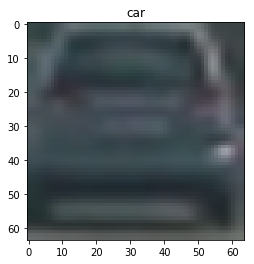

In [17]:
from keras.preprocessing import image

test_image = cv2.imread("train_data/car/GTI_Far/image0010.png")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image)
# print(test_image)
plt.title(cars_classifier_cnn.predict(test_image))
plt.show()

In [18]:
# def classify(file):
#     test_image = cv2.imread(file)
#     test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
#     prediction = cars_classifier_cnn.predict(test_image)
#     return prediction

# corrected_predictions = 0
# wrong_predictions = 0

# ######
# #### cars 
# ######
# print ( " Predicting CARS")
# for folder  in  sorted(glob.glob('train_data/car/*')):
#     print ( " Predicting CARS folder " + str(folder))
#     for file in glob.glob(folder+ "/*"):
#         prediction = classify(file)
#         if prediction == "car":
#             corrected_predictions +=1
#         else:
#             wrong_predictions +=1
#     print ("                                     ..... correct= {} , wrong={} "\
#            .format(corrected_predictions,wrong_predictions ))

# ######
# #### NON cars 
# ######
# print ( " ")
# print ( " Predicting NON CARS")
# for folder  in  sorted(glob.glob('train_data/non-car/*')):
#     print ( " Predicting NON CARS folder " + str(folder))
#     for file in glob.glob(folder + "/*"):
#         prediction = classify(file)
#         if prediction == "non-car":
#             corrected_predictions +=1
#         else:
#             wrong_predictions +=1
#     print ("                                     ..... correct= {} , wrong={} "\
#            .format(corrected_predictions,wrong_predictions ))

# print ( "*************************************************************")        
# print ( "**")        
# print ( "** Corrected predictions {}".format(corrected_predictions))        
# print ( "** Wrong     predictions {}".format(wrong_predictions))        
# print ( "*************************************************************")        



### SLIDING WINDOW COMPARISON CNN / SVM/ NEURAL NETWORK

In [19]:
class window_extractor:
    def __init__(self, image,               \
                 window_dimension=32,  \
                 x_start_stop=[None, None], \
                 y_start_stop=[350, None], \
                 x_overlap=0.5, y_overlap=0.5):
        
        self.image           = image
        self.xy_window       = (window_dimension, window_dimension)
        self.xy_overlap      = (x_overlap, y_overlap)
        self.x_start_stop    = x_start_stop
        self.y_start_stop    = y_start_stop
        
        # If x and/or y start/stop positions not defined, set to image size
        #     print (x_start_stop)
        if self.x_start_stop[0] == None:
            self.x_start_stop[0] = 0
        if self.x_start_stop[1] == None:
            self.x_start_stop[1] = self.image.shape[1]
        if self.y_start_stop[0] == None:
            self.y_start_stop[0] = 0
        if self.y_start_stop[1] == None:
            self.y_start_stop[1] = self.image.shape[0]

        # Compute the span of the region to be searched    
        self.xspan = self.x_start_stop[1] - self.x_start_stop[0]
        self.yspan = self.y_start_stop[1] - self.y_start_stop[0]
        
        # Compute the number of pixels per step in x/y
        self.nx_pix_per_step = np.int(self.xy_window[0]*(1 - self.xy_overlap[0]))
        self.ny_pix_per_step = np.int(self.xy_window[1]*(1 - self.xy_overlap[1]))
        
        # Compute the number of windows in x/y
        self.nx_buffer = np.int(self.xy_window[0]*(self.xy_overlap[0]))
        self.ny_buffer = np.int(self.xy_window[1]*(self.xy_overlap[1]))
        self.nx_windows = np.int((self.xspan-self.nx_buffer)/self.nx_pix_per_step) 
        self.ny_windows = np.int((self.yspan-self.ny_buffer)/self.ny_pix_per_step) 



    def get_windows(self):
        # Initialize a list to append window positions to
        self.window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(self.ny_windows):
            for xs in range(self.nx_windows):
                # Calculate window position
                startx = xs*self.nx_pix_per_step + self.x_start_stop[0]
                endx = startx + self.xy_window[0]
                starty = ys*self.ny_pix_per_step + self.y_start_stop[0]
                endy = starty + self.xy_window[1]
                # Append window position to list
                self.window_list.append([startx, starty, endx, endy])
        # Return the list of windows
        return self.window_list
    
    def draw_boxes(self,hot_windows, color=(0, 0, 255), thick=6):
        # Make a copy of the image
        imcopy = np.copy(self.image)
        tmp_window_list = hot_windows
        for bbox in tmp_window_list:
#             print ("bbox = " + str(bbox))
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, (bbox[0], bbox[1]),(bbox[2], bbox[3]), color, thick)
        # Return the image copy with boxes drawn
        return imcopy

    

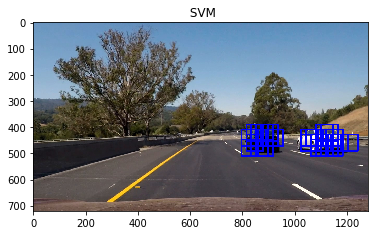

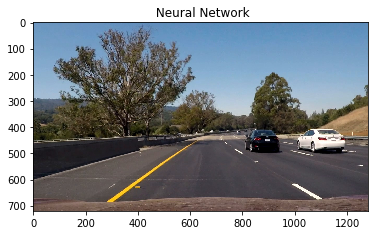

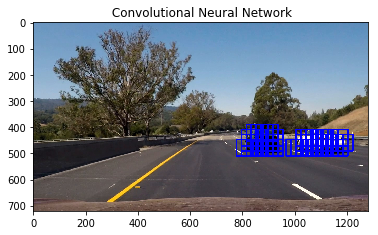

In [45]:
def test_comparison(filename, input_classifier):
    test_image = cv2.imread(filename)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    windows = []

    windows_ext = window_extractor(test_image, 
                                   window_dimension=64, 
                                   x_overlap = 0.7,
                                   y_overlap = 0.7,
                                   x_start_stop = [340,None],
                                   y_start_stop = [390,510])

    for x in windows_ext.get_windows():
         windows.append(x)

    hot_windows = []
    for window in windows:
        test_img = test_image[window[1]:window[3], window[0]:window[2]]
        test_img = cv2.resize(test_img, (64,64))
        
        if input_classifier.type == "CNN":
            prediction = input_classifier.predict(test_img)
            if prediction == "car":
                hot_windows.append(window)
        else:
            features         = extractor.get_all_features(test_img)
            features_reshaped = np.array(features).reshape(1, -1)
            test_features     = input_classifier.X_scaler.transform(np.array(features).reshape(1, -1))
            prediction        = input_classifier.clf.predict(test_features)

            if prediction == 1:
                hot_windows.append(window)

    tmp_image_hot = window_extractor(test_image).draw_boxes(hot_windows)
    
    return tmp_image_hot, hot_windows

test_file = "test_images2/image4.jpg"

### SVM
image_hot_svm, hot_windows_svm = test_comparison(test_file, cars_classifier_svm)

plt.imshow(image_hot_svm)
plt.title(" SVM")
plt.show()

### HOG NN
image_hot_hog_nn , hot_windows_hog_nn = test_comparison(test_file, cars_classifier_hog_nn)
plt.imshow(image_hot_hog_nn)
plt.title(" Neural Network")
plt.show()

### CNN
image_cnn,hot_windows_cnn  = test_comparison(test_file, cars_classifier_cnn)
plt.imshow(image_cnn)
plt.title(" Convolutional Neural Network")
plt.show()


# plt.title(" Convolutional Neural Network ")


### Now defining the Heat map to include the recognized Car in a Box...


In [21]:
from scipy.ndimage.measurements import label

class heat_map:
    def __init__(self, boxes_list, image):
            self.boxes = boxes_list
            self.heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
            self.image = np.copy(image)
            
    
    def add_heat(self):
        for box in self.boxes :
            # Assuming each "box" takes the form [x1, y1, x2, y2]
            self.heatmap[box[1]:box[3], box[0]:box[2]] += 1

        # Return updated heatmap

    def apply_threshold(self,threshold):
        # Zero out pixels below the threshold
        self.heatmap[self.heatmap < threshold] = 0
        # Return thresholded map

    def draw_labeled_bboxes(self):
        #scipy.ndimage.measurements.label
        self.labels = label(self.heatmap)
        # Iterate through all detected cars
        self.boxes = []
        for car_number in range(1, self.labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (self.labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ([np.min(nonzerox), np.min(nonzeroy),np.max(nonzerox), np.max(nonzeroy)])
            
            # Box discard - dimension that are improbable to  contain cars 
            if self.hot_boxes_discard(bbox) == True:
                pass
            else:
                # Draw the box on the image
                cv2.rectangle(self.image, (bbox[0], bbox[1]),(bbox[2], bbox[3]), (0,255,0), 6)
                self.boxes.append(bbox)

    def hot_boxes_discard(self, box):
        ### discard hot boxes that are unlikely to contain a car because of false proportions
        box = np.copy(box).ravel()
        
        x_dimension = np.abs(box[2] - box[0])
        y_dimension = np.abs(box[3] - box[1])
        discard = False

        if y_dimension > 0:
            ratio = x_dimension / y_dimension
            if ratio < 0.6 or ratio > 3:
                print( " discard because of ratio  " +str(ratio))
                discard = True

        return discard

#### Applying heatmap to SVM

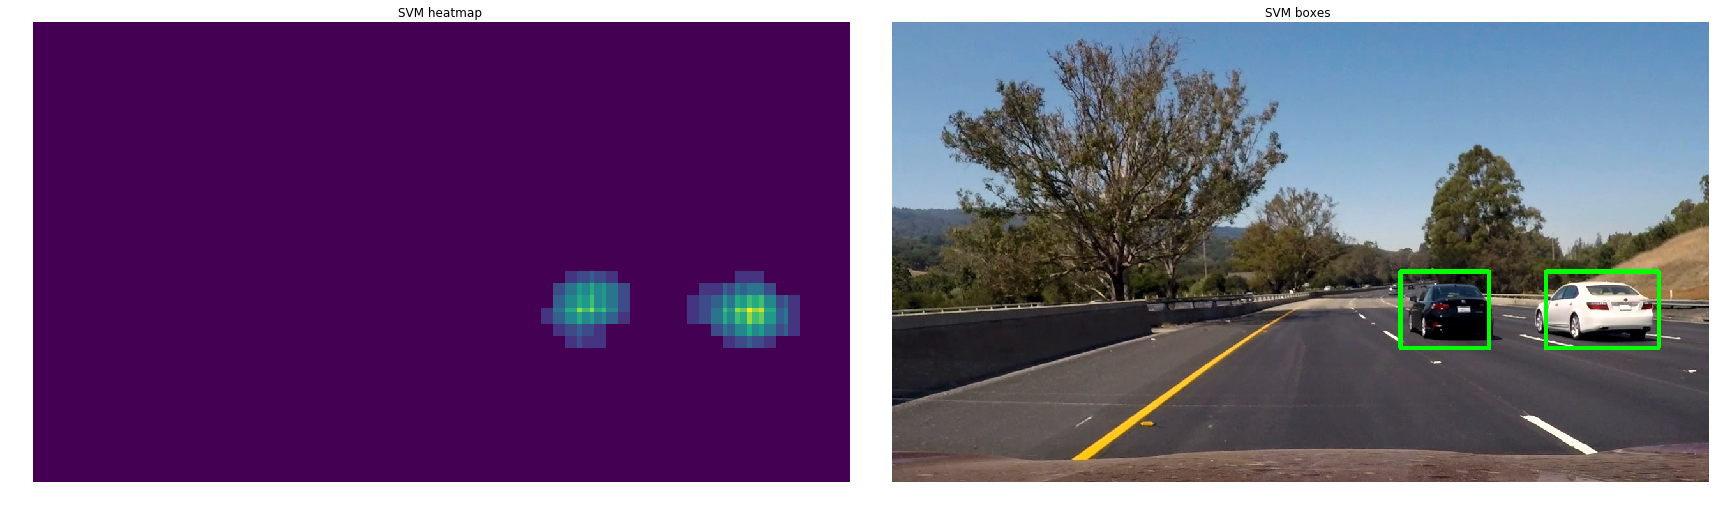

In [22]:
test_image = cv2.imread("test_images2/image4.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    
heat = heat_map(hot_windows_svm, test_image)
heat.add_heat()
heat.apply_threshold(threshold=np.average(heat.heatmap[heat.heatmap> 0 ])*.3)
heat.draw_labeled_bboxes()

#################
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(np.clip(heat.heatmap,0,255))    
ax1.set_title("SVM heatmap ")
ax1.axis('off')

ax2.imshow(heat.image)  
ax2.set_title("SVM boxes ")
ax2.axis('off')
##################
plt.show()



#### Applying heatmap to HOG Neural Network

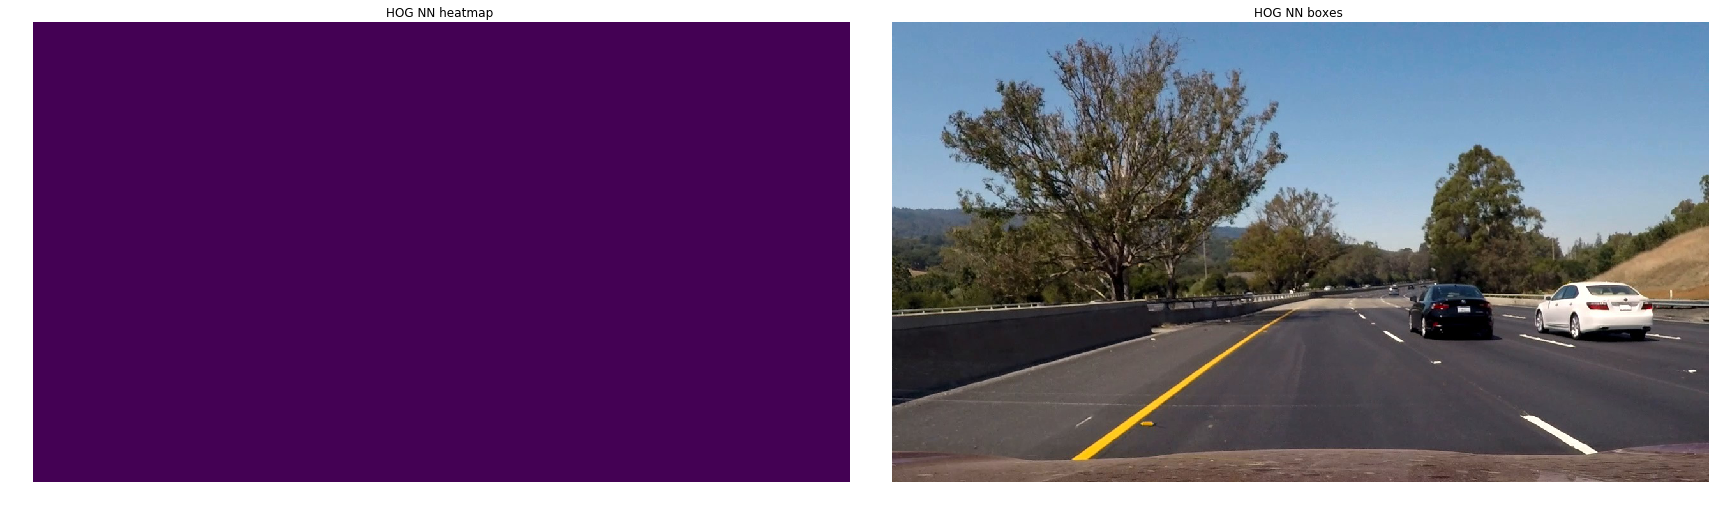

In [23]:
test_image = cv2.imread("test_images2/image4.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    
heat = heat_map(hot_windows_hog_nn, test_image)
heat.add_heat()
heat.apply_threshold(threshold=np.average(heat.heatmap[heat.heatmap> 0 ])*.3)
heat.draw_labeled_bboxes()

#################
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(np.clip(heat.heatmap,0,255))    
ax1.set_title("HOG NN heatmap ")
ax1.axis('off')

ax2.imshow(heat.image)  
ax2.set_title("HOG NN boxes ")
ax2.axis('off')
##################
plt.show()




#### Applying heatmap to Convolutional Neural Network

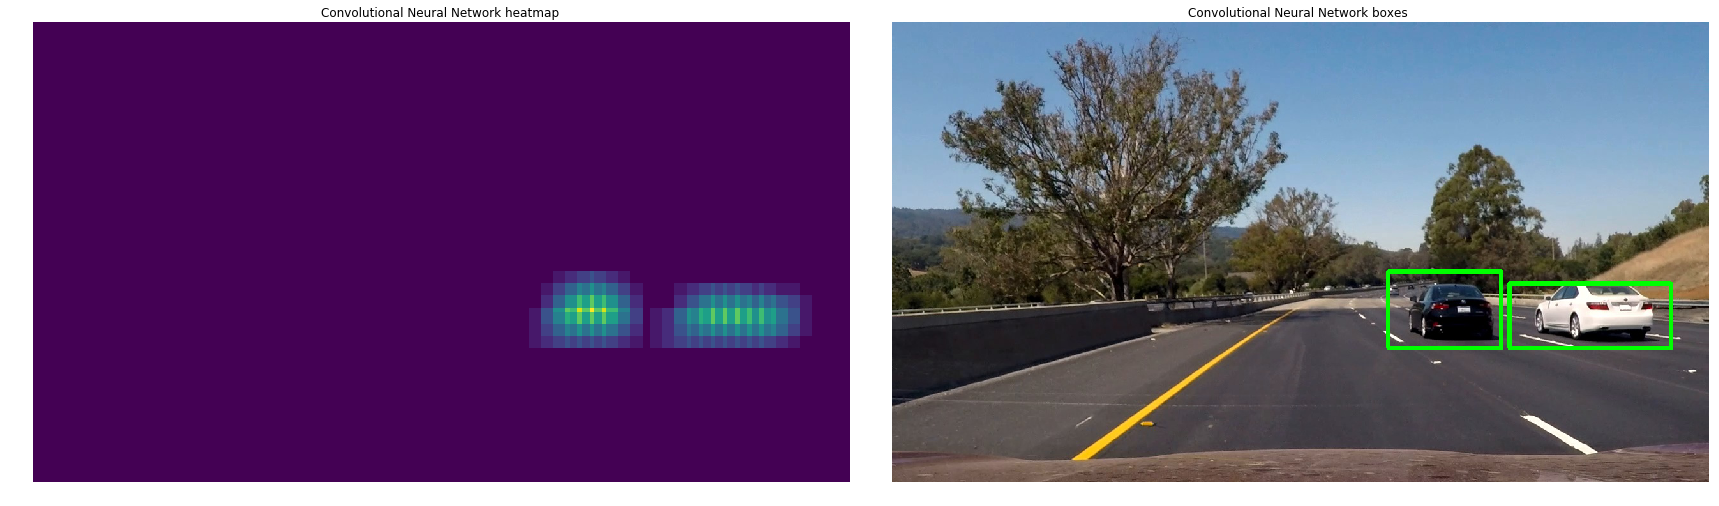

In [24]:
test_image = cv2.imread("test_images2/image4.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    
heat = heat_map(hot_windows_cnn, test_image)
heat.add_heat()
heat.apply_threshold(threshold=np.average(heat.heatmap[heat.heatmap> 0 ])*.2)
heat.draw_labeled_bboxes()

#################
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(np.clip(heat.heatmap,0,255))    
ax1.set_title("Convolutional Neural Network heatmap ")
ax1.axis('off')

ax2.imshow(heat.image)  
ax2.set_title("Convolutional Neural Network boxes ")
ax2.axis('off')
##################
plt.show()

### Defining the class pipeline

In [41]:
class pipeline:
    def __init__(self, extractor, cars_classifier, average_moltiplier, debug=False, debug_image=False):
        self.detector = image_car_detector(extractor)
        self.cars_classifier = cars_classifier
        self.cars_classifier.load_classifier()
        self.debug= debug
        self.boxes_history = []
        self.discarded = 0
        self.average_moltiplier = average_moltiplier
        self.debug_image = debug_image

    def insert_boxes_history(self, boxes):
        if len(boxes ) > 0:
            
            self.boxes_history.append(boxes)
            ### keeping only the last 3 fits
            self.boxes_history = self.boxes_history[-3:]

        
    def searchfor_windows_first(self):
            self.windows = []
            ##########  scale = 1
            windows_ext = window_extractor(self.image, 
                                           window_dimension=64, 
                                           x_overlap = 0.6,
                                           y_overlap = 0.8,
                                           x_start_stop = [340,None],
                                           y_start_stop = [390,510])
            
            for x in windows_ext.get_windows():
                 self.windows.append(x)

            ##########  scale = 1.25      
            windows_ext = window_extractor(image, 
                                           window_dimension=int(64*1.25), 
                                           x_overlap = 0.6,
                                           y_overlap = 0.8,
                                           x_start_stop = [340,None],
                                           y_start_stop = [400,560])
            for x in windows_ext.get_windows():
                 self.windows.append(x)


            # ###########  scale = 1.5     
            windows_ext = window_extractor(image, 
                                           window_dimension=int(64*1.5), 
                                           x_overlap = 0.6,
                                           y_overlap = 0.8,
                                           x_start_stop = [340,None],
                                           y_start_stop = [400,600])
            for x in windows_ext.get_windows():
                 self.windows.append(x)

        
            # ###########  scale = 1.75   
            windows_ext = window_extractor(image, 
                                           window_dimension=int(64*1.75), 
                                           x_overlap = 0.5,
                                           y_overlap = 0.8,
                                           x_start_stop = [340,None],
                                           y_start_stop = [400,656])
            for x in windows_ext.get_windows():
                 self.windows.append(x)

    def search_cars_by_steps(self,image):
        
        self.image = image 

        self.windows = []
        self.hot_windows = []
        
        ########
        # creating a list of boxes
        ########
        tmp_image = self.searchfor_windows_first()
        if self.debug_image:
            image_tmp = window_extractor(self.image).draw_boxes(self.windows)
            plt.imshow(image_tmp)    
            plt.axis("off")
            plt.title(" Boxes drawn on the image ")
            plt.show()

            

        ########
        # search for car detection in the above calculated boxes
        ########
        self.hot_windows = []
        self.hot_windows = self.detector.search_windows(self.image, self.windows, cars_classifier=self.cars_classifier)
        if self.debug_image:
            tmp_image_hot = window_extractor(self.image).draw_boxes(self.hot_windows)
            plt.imshow(tmp_image_hot)  
            plt.axis("off")
            plt.title(" Car boxes detected ")
            plt.show()

            
        ########
        # heat map
        ########
        self.heat = heat_map(self.hot_windows, self.image)
        self.heat.add_heat()
        if len(self.heat.heatmap[self.heat.heatmap>0]) > 0:
            self.heat.apply_threshold(threshold=
                                      np.average(self.heat.heatmap[self.heat.heatmap> 0 ])*
                                                 self.average_moltiplier)
        ########
        # discard unrealistic boxes
        ########
        number_of_boxes =  len(np.array(self.heat.boxes))   
        self.heat.boxes = np.array(self.heat.boxes).reshape(number_of_boxes,4)


        self.heat.draw_labeled_bboxes()
        if self.debug_image:
            plt.imshow(self.heat.image)    
            plt.axis("off")

            plt.title(" First heat map")

            plt.show()


        if self.debug:
            print ( " ")
            print (  " ------- actual self.heat.boxes = " )
            print (str(self.heat.boxes))

        
        self.insert_boxes_history(self.heat.boxes)
        
        #####################
        #### frame history averaging 
        #####################

        numbers_of_actual_boxes = len(self.heat.boxes)
        
        for i, box in enumerate(self.calc_history_average()):
            if self.debug:
                print ("*******************************")
            ## in case is missing I will append the history box
            if self.debug:
                print ( " i = " + str(i) + " numbers_of_actual_boxes = " + str(numbers_of_actual_boxes))
            if i +1 > numbers_of_actual_boxes:
                
                if self.debug: 
                    print ( " i +1 > numbers_of_actual_boxes ****** appending "+ str(box))
                    
                if numbers_of_actual_boxes == 0:
                    self.heat.boxes = [box]
                    print ( " self.heat.boxes " + str(self.heat.boxes))
                else:
                    self.heat.boxes = np.vstack((self.heat.boxes,box))
                numbers_of_actual_boxes += 1
            if self.debug:print ("history box average i = " + str(i) )
            if self.debug:print ("   -->  avg.   = "  + str(box) )
            if self.debug:print ("   -->  actual = " + str(self.heat.boxes[i]))
            if self.debug:print ( "  -->  mean_squared_error = " + str(self.calc_RMSE(box , self.heat.boxes[i] )))
            
            # actual box substitution with average history boxes
            if self.calc_RMSE(box , self.heat.boxes[i] ) > 5.4 :
                print ( "Current frame discarded ")
                self.discarded += 1
                self.heat.boxes[i] = box 
                
        ###########################
        return self.heat.image

    def calc_RMSE(self, vector1, vector2):
        sum_squared_diff = 0
        n = 0
        
        if self.debug:
            print (  " vector1 = " + str(vector1))
            print (  " vector2 = " + str(vector2))

        for element1, element2 in zip(vector1, vector2):
            n +=1
            sum_squared_diff += (element1 - element2) **2
        mean_squared_error_result = np.sqrt(sum_squared_diff / n)
        return mean_squared_error_result
            
    def put_zero_missing_history_elements(self):
        if self.debug:
            print (" -----------------------------")
            print (" ---- put_zero_missing_history_elements ----")
            print (" -----------------------------")
            print ( pipeline1.boxes_history)
            
        self.max_length = 0
        for boxes in pipeline1.boxes_history:
#             print ( "-----------------------------")
#             print (boxes)
            len_boxes = 0
            for row in boxes:
                if np.sum(row) > 0 :
                    len_boxes +=1
            if len_boxes > self.max_length:
                self.max_length = len_boxes
        if self.debug:print (" --")

        for i, boxes in enumerate(pipeline1.boxes_history):
            if self.debug:
                print ( " ----")
                print ( " ------ processing box " + str(i))
                print ( boxes)
                print ( " ----")
                print ( " ----")

            # excluding the eventual zero boxes 
            pipeline1.boxes_history[i] = pipeline1.boxes_history[i][:self.max_length]
            
            for to_add in range ( len(boxes), self.max_length):
               if self.debug:print ( " ** adding element to box " + str(i))
               pipeline1.boxes_history[i] = np.vstack((pipeline1.boxes_history[i], [0,0,0,0]))
                
        if self.debug:print ( pipeline1.boxes_history)
        if self.debug:print (" --")




        
    def calc_history_average(self):
        
        ### fill the missing elements with zero
        self.put_zero_missing_history_elements()
        
        boxes_sum = np.zeros((self.max_length,4))
        boxes_n = np.zeros((self.max_length,4))

        if self.debug:
            print (" _----------- ")
            print (pipeline1.boxes_history)
            print (" _----------- ")

        for element in np.array(pipeline1.boxes_history):
            if self.debug:print (element )
            if self.debug:print ("####")
            n = 0
            for i,box in enumerate(element):
                # avoid the average on missing elements
                if np.sum(box) == 0:
                    pass
                else:
                    boxes_n[i] += 1
                boxes_sum[i] += box

        return boxes_sum/boxes_n

    

In [51]:
os.path.split("test_images/image1.png")[-1]

'image1.png'

In [55]:
import cv2
pipeline1 = pipeline(extractor, 
                     cars_classifier=cars_classifier_cnn,
                     average_moltiplier=0.6, 
                     debug=False, 
                     debug_image=False)
# for i in range(1,52):
#     image_name = "test_images2/image" + str(i) + ".jpg"
for image_name  in  sorted(glob.glob('test_images/*')):
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_heat = pipeline1.search_cars_by_steps(image)
    print ( " saving .. " + "output_images/"+ os.path.split(image_name)[-1])
    cv2.imwrite(image_heat, "output_images/"+ os.path.split(image_name)[-1])
    
    plt.title(" pipeline output" + str(image_name))
    plt.imshow(image_heat)
    plt.show()
    print ( " *******************************************     ")
    print ( " *************** finish     ")
    print ( " *******************************************     ")



    


 .. classifier loaded 
 saving .. output_images/test1.jpg


TypeError: bad argument type for built-in operation

In [ ]:
pipeline1 = pipeline(extractor, 
                     cars_classifier=cars_classifier_cnn,
                     average_moltiplier=0.4, 
                     debug=False, 
                     debug_image=False)

from moviepy.editor import VideoFileClip
output_video_name = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
clip2 = clip1.subclip(0,2)
output_video = clip2.fl_image(lambda x: pipeline1.search_cars_by_steps(x)) #NOTE: this function expects color images!!
%time output_video.write_videofile(output_video_name, audio=False)
print ("Completed")



In [37]:
pipeline1 = pipeline(extractor, 
                     cars_classifier=cars_classifier_cnn,
                     average_moltiplier=0.4, 
                     debug=False, 
                     debug_image=False)

from moviepy.editor import VideoFileClip
output_video_name = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip2 = clip1.subclip(0,5)
output_video = clip2.fl_image(lambda x: pipeline1.search_cars_by_steps(x)) #NOTE: this function expects color images!!
%time output_video.write_videofile(output_video_name, audio=False)
print ("Completed")




 .. classifier loaded 
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 13%|█▎        | 17/126 [00:37<03:34,  1.97s/it]

 self.heat.boxes [array([ 564.        ,  427.33333333,  653.66666667,  517.        ])]


 14%|█▍        | 18/126 [00:39<03:31,  1.96s/it]

 self.heat.boxes [array([ 564.        ,  427.33333333,  653.66666667,  517.        ])]


 15%|█▌        | 19/126 [00:41<03:33,  2.00s/it]

 self.heat.boxes [array([ 564.        ,  427.33333333,  653.66666667,  517.        ])]


 16%|█▌        | 20/126 [00:43<03:33,  2.01s/it]

 self.heat.boxes [array([ 564.        ,  427.33333333,  653.66666667,  517.        ])]


 17%|█▋        | 21/126 [00:45<03:31,  2.02s/it]

 self.heat.boxes [array([ 564.        ,  427.33333333,  653.66666667,  517.        ])]


 17%|█▋        | 22/126 [00:47<03:28,  2.01s/it]

 self.heat.boxes [array([ 564.        ,  427.33333333,  653.66666667,  517.        ])]


 18%|█▊        | 23/126 [00:49<03:24,  1.99s/it]

 self.heat.boxes [array([ 564.        ,  427.33333333,  653.66666667,  517.        ])]


 19%|█▉        | 24/126 [00:51<03:21,  1.98s/it]

 self.heat.boxes [array([ 564.        ,  427.33333333,  653.66666667,  517.        ])]


 20%|█▉        | 25/126 [00:53<03:22,  2.00s/it]

 self.heat.boxes [array([ 564.        ,  427.33333333,  653.66666667,  517.        ])]


 25%|██▌       | 32/126 [01:07<03:12,  2.04s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 27%|██▋       | 34/126 [01:11<03:05,  2.02s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 28%|██▊       | 35/126 [01:13<02:59,  1.98s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 29%|██▊       | 36/126 [01:15<02:57,  1.97s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 29%|██▉       | 37/126 [01:17<02:59,  2.02s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 30%|███       | 38/126 [01:19<02:55,  1.99s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 31%|███       | 39/126 [01:21<02:52,  1.98s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 32%|███▏      | 40/126 [01:23<02:48,  1.96s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 33%|███▎      | 41/126 [01:25<02:47,  1.97s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 33%|███▎      | 42/126 [01:27<02:44,  1.96s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 34%|███▍      | 43/126 [01:29<02:41,  1.95s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 35%|███▍      | 44/126 [01:31<02:38,  1.93s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 36%|███▌      | 45/126 [01:33<02:34,  1.91s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 37%|███▋      | 46/126 [01:35<02:35,  1.94s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 37%|███▋      | 47/126 [01:37<02:33,  1.95s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 38%|███▊      | 48/126 [01:39<02:31,  1.94s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 39%|███▉      | 49/126 [01:41<02:28,  1.93s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 40%|███▉      | 50/126 [01:43<02:27,  1.94s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 40%|████      | 51/126 [01:45<02:26,  1.95s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 41%|████▏     | 52/126 [01:47<02:24,  1.95s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 42%|████▏     | 53/126 [01:49<02:23,  1.96s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 43%|████▎     | 54/126 [01:50<02:20,  1.95s/it]

 self.heat.boxes [array([ 340.,  438.,  403.,  501.])]


 99%|█████████▉| 125/126 [04:19<00:02,  2.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 9min 9s, sys: 35.5 s, total: 9min 45s
Wall time: 4min 20s
Completed
